In [1]:
import numpy as np
import util
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
class MagneticMirror2D(object):

    #######################################################################
    # Begin physical parameters                                           #
    #######################################################################

    # domain size in meter
    Lx = 1e-2 # r direction
    Lz = 1e-1

    # spatial resolution in number of cells
    Nx = 32
    Nz = 256

    # mirror ratio
    R = 10.0
    B_max = 30.0  # T

    # use a reduced ion mass for faster simulations
    m_ion = 400.0 * util.constants.m_e
    # m_ion = util.constants.m_p

    # initial seed macroparticle density
    nppc_seed = 5  # 800

    # total simulation time in ion thermal crossing times
    crossing_times = 1

    def __init__(self):
        # plasma density m^{-3}
        self.n0 = 1e16

        # temperature
        self.Te = 400 # eV
        self.Ti = self.Te

        self.dx = self.Lx / self.Nx
        self.dz = self.Lz / self.Nz

        # calculate electron plasma frequency
        w_pe = util.plasma_freq(self.n0)
        self.dt = 0.07 / w_pe
        # simulation timestep from electron CFL
        # self.dt = self.dz / (5.0 * util.thermal_velocity(self.Te, util.constants.m_e))

        # calculate the ion crossing time to get the total simulation time
        ion_crossing_time = self.Lz / \
            util.thermal_velocity(self.Ti, self.m_ion)
        self.total_steps = int(np.ceil(
            self.crossing_times * ion_crossing_time / self.dt
        ))
        self.diag_steps = int(self.total_steps / 20.0)

        # calculate the flux from the thermal plasma reservoir
        self.flux_e = (
            self.n0 * util.thermal_velocity(self.Te, util.constants.m_e) / np.sqrt(2.0 * np.pi)
        )
        # self.flux_i = self.flux_e * np.sqrt(util.constants.m_e / self.m_ion)
        self.flux_i = (
            self.n0 * util.thermal_velocity(self.Ti, self.m_ion)
        )

        # check spatial resolution
        self.debye_length = util.debye_length(self.Te, self.n0)

        print("Starting simulation with parameters:")
        print(f"    Lz = {self.Lz}m, Lx = {self.Lx}m")
        print(f"    Nz = {self.Nz}, Nx = {self.Nx}")
        print(f"    dz = {self.dz*1e6:.1f}um, dx = {self.dx*1e6:.1f}um")
        print(f"    Debye length = {self.debye_length*1e6:.1f} um")
        print(f"    Electron plasma frequency = {w_pe:.1f} Hz")
        print(f"    T_e = T_i = {self.Te:.3f} eV")
        print(f"    n0 = {self.n0:.1e} m^-3")
        print(f"    M/m = {self.m_ion/util.constants.m_e:.0f}")
        # print(f"    flux_e = {self.flux_e*util.constants.e:.1f} A/m2")
        print(f"    flux_i = {self.flux_i*util.constants.e:.1f} A/m2")
        print(f"    Ion crossing time: {ion_crossing_time}")
        print(f"    Ion crossing steps: {ion_crossing_time / self.dt:.0f}")
        print(f"    Total steps = {self.total_steps}")
mirror = MagneticMirror2D()


Starting simulation with parameters:
    Lz = 0.1m, Lx = 0.01m
    Nz = 256, Nx = 32
    dz = 390.6um, dx = 312.5um
    Debye length = 1486.0 um
    Electron plasma frequency = 5641460231.2 Hz
    T_e = T_i = 400.000 eV
    n0 = 1.0e+16 m^-3
    M/m = 400
    flux_i = 950.2 A/m2
    Ion crossing time: 1.686131268092182e-07
    Ion crossing steps: 13589
    Total steps = 13589


In [9]:
num_cores = 2**np.arange(8)
time_per_step = 1 # second
total_time = np.round(time_per_step*mirror.total_steps / num_cores / 3600, 1) # in hours
pd.DataFrame({"Cores": num_cores, "Total Hours": total_time, "Total Days": np.round(total_time/24,1)})

,Cores,Total Hours,Total Days
0,1,3.8,0.2
1,2,1.9,0.1
2,4,0.9,0.0
3,8,0.5,0.0
4,16,0.2,0.0
5,32,0.1,0.0
6,64,0.1,0.0
7,128,0.0,0.0


We can have a much more accurate estimate by using the output log from previous runs

Processing diags32x256-1ict/output-11321410.log ......done!
Estimated to take 7.67648472287793 hours using 32 cores and 2 OMP threads


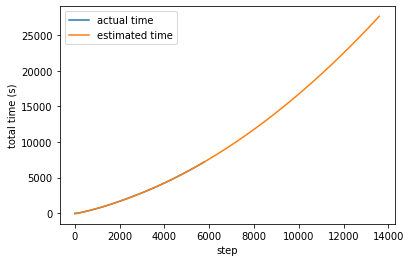

In [7]:
output_file = "diags32x256-1ict/output-11321410.log"
specs, time_data = util.extract_data(output_file)
steps, total_times = time_data[:,0], time_data[:,4].cumsum()
plt.plot(steps, total_times)
plt.xlabel("step")
plt.ylabel("total time (s)")

p = np.polyfit(steps, total_times, 2)
estimate_steps = np.linspace(1,mirror.total_steps)
estimate_times = np.polyval(p, estimate_steps)
plt.plot(estimate_steps, estimate_times)
plt.legend(["actual time", "estimated time"])

print(f"Estimated to take {estimate_times[-1]/3600} hours using {specs['cores']} cores and {specs['omp_threads']} OMP threads")